In [59]:
import numpy as np
import matplotlib.pyplot as plt

import gpcg

import scipy.sparse as sps
from scipy.ndimage import gaussian_filter
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg as scipy_cg
from scipy.sparse.linalg import aslinearoperator

import math

from PIL import Image, ImageOps, ImageFilter, ImageDraw, ImageFont

from csias import CSIASSolver1D

# Load image

In [6]:
# Problem parameters
noise_sigma = 0.2

In [9]:
# Open an image
img_path = "cameraman.png"
img = Image.open(img_path)
img = ImageOps.grayscale(img)
img = np.asarray(img)
img = img/255.0
img_shape = img.shape

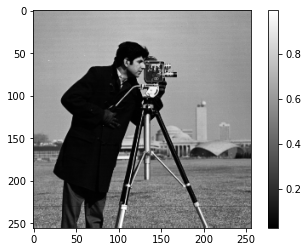

In [10]:
plt.imshow(img, cmap="gray")
plt.colorbar()
plt.show()

# Set up test problem

In [40]:
# Create txt image for the phase part
txt_img = 255*np.ones_like(img)
txt_img = Image.fromarray(txt_img)

I1 = ImageDraw.Draw(txt_img)
fnt = ImageFont.truetype("Arial.ttf", 30)
I1.text((5, 7), "This is a test.", font=fnt, fill=(0,))
I1.text((5, 215), "Can you read me?", font=fnt, fill=(0,))

# fnt = ImageFont.truetype("arial.ttf", 30)
# I1.text((5, 7), "This is a test.", font=fnt, fill=(0,))
# I1.text((5, 215), "Can you read me?", font=fnt, fill=(0,))

txt_img = ImageOps.grayscale(txt_img)
txt_img = np.asarray(txt_img)
txt_img = (txt_img/255.0)
#txt_img = txt_img % np.pi

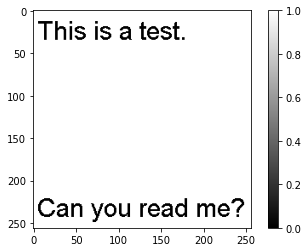

In [41]:
plt.imshow(txt_img, cmap="gray")
plt.colorbar()
plt.show()

In [42]:
# Make complex-valued image
ground_truth = img*np.exp(1j*txt_img) 

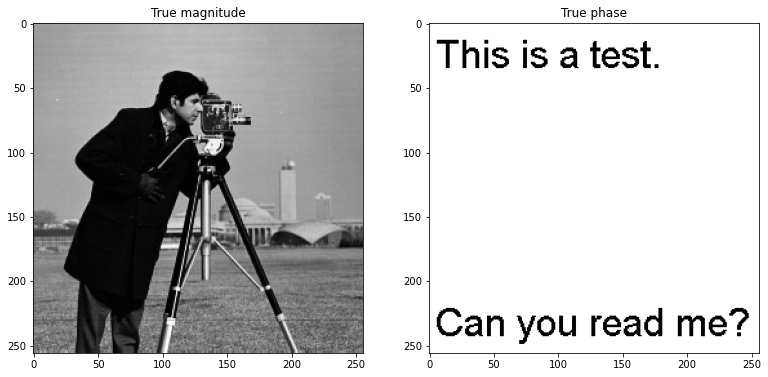

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(13,8))

axs[0].imshow(np.abs(ground_truth), cmap="gray")
axs[0].set_title("True magnitude")
axs[1].imshow(np.angle(ground_truth), cmap="gray")
axs[1].set_title("True phase")

plt.show()

In [45]:
# Take fft
ground_truth_fft = np.fft.fft2(ground_truth, norm="ortho")

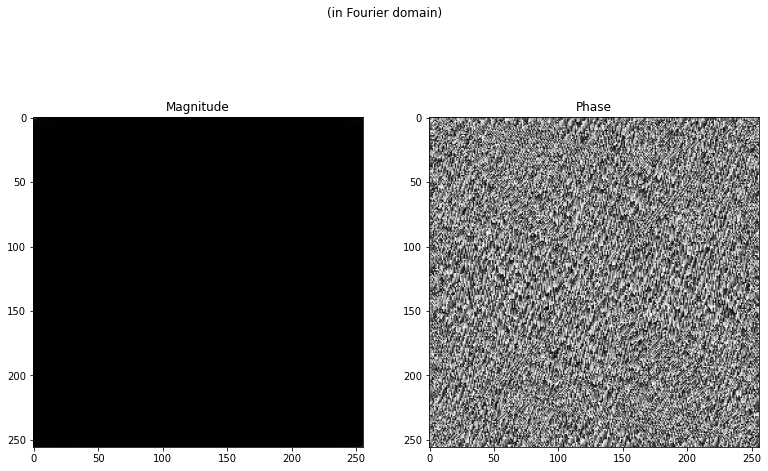

In [98]:
fig, axs = plt.subplots(1, 2, figsize=(13,8))

axs[0].imshow(np.abs(ground_truth_fft), cmap="gray")
axs[0].set_title("Magnitude")
axs[1].imshow(np.angle(ground_truth_fft), cmap="gray")
axs[1].set_title("Phase")

fig.suptitle("(in Fourier domain)")

plt.show()

In [99]:
# add noise
noise_sigma = 0.3
noisy_obs = np.fft.fft2(ground_truth, norm="ortho") + (noise_sigma/2)*np.random.normal(size=ground_truth.shape) + 1j*(noise_sigma/2)*np.random.normal(size=ground_truth.shape)
back_proj = np.fft.ifft2(noisy_obs, norm="ortho")

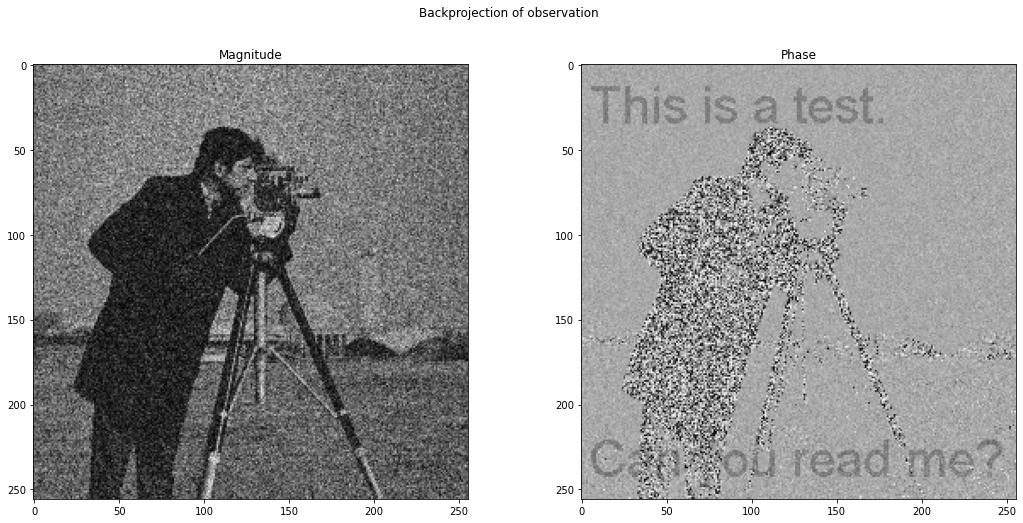

In [100]:
fig, axs = plt.subplots(1, 2, figsize=(18,8))

axs[0].imshow(np.abs(back_proj), cmap="gray")
axs[0].set_title("Magnitude")
axs[1].imshow(np.angle(back_proj), cmap="gray")
axs[1].set_title("Phase")

fig.suptitle("Backprojection of observation")

plt.show()

# Solver class

In [125]:
class CSIASSolver2D:

    def __init__(self, y, R, noise_sigma=1.0):

        self.y = y
        self.R = R
        self.noise_sigma = noise_sigma
        self.grid_shape = y.shape
        self.n = math.prod(self.grid_shape)

        # Compute MAP phase
        self.map_phase = np.angle(np.fft.ifft2(y, norm="ortho"))

        # RHS vec
        tmp = (1/(self.noise_sigma**2))*np.exp(-1j*self.map_phase)*np.fft.ifft2(y, norm="ortho")
        self.rhs_vec = np.real( tmp + tmp.conj() )
        self.rhs_vec_flat = self.rhs_vec.flatten()


    def solve_with_tikhonov(self, reg_lambda=1, cg_maxits=100, cg_tol=1e-3):
        """Solves the problem using Tikhonov regularization on the magnitude."""
        
        # Make coefficient matrix
        coeff_mat = (reg_lambda*(self.R.T @ self.R)) + aslinearoperator( (2/(self.noise_sigma**2))*sps.eye(self.n) )

        # Solve bound-constrained problem using GPCG
        lower_bounds = np.zeros(coeff_mat.shape[0])
        upper_bounds = np.inf*np.ones(coeff_mat.shape[0])
        gpcg_solver = gpcg.GPCGSolver(coeff_mat, self.rhs_vec_flat, lower_bounds=lower_bounds, upper_bounds=upper_bounds)
        gpcg_solve = gpcg_solver.solve(maxits=cg_maxits, tol=cg_tol)
        gpcg_sol = gpcg_solve["x"]
        gpcg_sol = gpcg_sol.reshape(self.grid_shape)

        data = {
            "magnitude": gpcg_sol,
            "phase": self.map_phase,
        }

        return data
    


    def solve_with_ias(self, hyperparameters, n_iterations=20):
        """Solves the problem using the IAS method."""

        # Initialization
        magnitude = np.ones(self.n)
        beta = np.ones(self.R.shape[0])
        
        for j in range(n_iterations):
            
            # Update r
            magnitude = self.ias_magnitude_update(beta, prev_magnitude=magnitude)

            # Update beta
            beta = self.ias_beta_update(magnitude, hyperparameters)

        data = {
            "magnitude": magnitude.reshape(self.grid_shape),
            "phase": self.map_phase,
            "beta": beta,
        }

        return data



    def ias_magnitude_update(self, beta, prev_magnitude=None, cg_maxits=100, cg_tol=1e-3):
        """Computes the magnitude update for fixed beta."""

        # Make coefficient matrix
        coeff_mat = (self.R.T @ aslinearoperator( sps.diags(1.0/beta) )  @ self.R) + aslinearoperator( (2/(self.noise_sigma**2))*sps.eye(self.n) )

        # Solve bound-constrained problem using GPCG
        lower_bounds = np.zeros(coeff_mat.shape[0])
        upper_bounds = np.inf*np.ones(coeff_mat.shape[0])
        gpcg_solver = gpcg.GPCGSolver(coeff_mat, self.rhs_vec_flat, lower_bounds=lower_bounds, upper_bounds=upper_bounds)
        gpcg_solve = gpcg_solver.solve(x0=prev_magnitude, maxits=cg_maxits, tol=cg_tol)
        gpcg_sol = gpcg_solve["x"]

        return gpcg_sol



    def ias_beta_update(self, magnitude, hyperparameters):
        """Computes the beta update for fixed magnitude."""

        # Hyper-prior parameters
        r, s, vartheta = hyperparameters["r"], hyperparameters["s"], hyperparameters["vartheta"]
        
        assert (r == -1) or (r == 1), "Currently only supporting r = -1 or r = 1."

        if r == 1:

            eta = (r*s) - 1.5
            Rx = self.R @ magnitude

            root_term = (eta**2) + (4/vartheta)*( 0.5*(Rx**2)  )
            new_beta = (vartheta/2)*(  eta + np.sqrt(root_term)   ) 

            return new_beta 
          
        else:

            eta = (r*s) - 1.5
            eta = -1*eta
            Rx = self.R @ magnitude
            new_beta = (  vartheta + 0.5*(Rx**2)  )/eta

            return new_beta

In [126]:
# Set up regularization matrix
def build_1d_first_order_grad(N: int, boundary: str = "periodic"):
    """Constructs a SciPy sparse matrix that extracts the (1D) discrete gradient of an input signal.
    Boundary parameter specifies how to handle the boundary conditions.
    """
    
    assert boundary in ["none", "periodic", "zero"], "Invalid boundary parameter."
    
    d_mat = sps.eye(N)
    d_mat.setdiag(-1,k=-1)
    #d_mat = sps.csc_matrix(d_mat)
    d_mat = d_mat.tolil()
    
    if boundary == "periodic":
        d_mat[0,-1] = -1
    elif boundary == "zero":
        pass
    elif boundary == "none":
        d_mat = d_mat[1:,:]
    else:
        pass
    
    return d_mat


def build_2d_first_order_grad(M: int, N: int, boundary = "zero"):
    """Constructs a SciPy sparse matrix that extracts the discrete gradient of an input image.
    Assumes periodic BCs. Input image should have original dimension (M,N), must be flattened
    to compute matrix-vector product. First set is horizontal gradient, second is vertical.
    """

    # Construct our differencing matrices
    d_mat_horiz = build_1d_first_order_grad(N, boundary=boundary)
    d_mat_vert = build_1d_first_order_grad(M, boundary=boundary)
    
    # Build the combined matrix
    eye_vert = sps.eye(M)
    d_mat_one = sps.kron(eye_vert, d_mat_horiz)
    
    eye_horiz = sps.eye(N)
    d_mat_two = sps.kron(d_mat_vert, eye_horiz)

    full_diff_mat = sps.vstack([d_mat_one, d_mat_two])
    
    return full_diff_mat


In [127]:
# Set up regularization R
M, N = img_shape
R = build_2d_first_order_grad(M, N, boundary="none")
R = aslinearoperator(R)

# Set up solver
solver = CSIASSolver2D(noisy_obs, R, noise_sigma=noise_sigma)

In [128]:
# Tikhonov solution
reg_lambda = 1e2
data = solver.solve_with_tikhonov(reg_lambda=reg_lambda, cg_maxits=10000, cg_tol=1e-5)

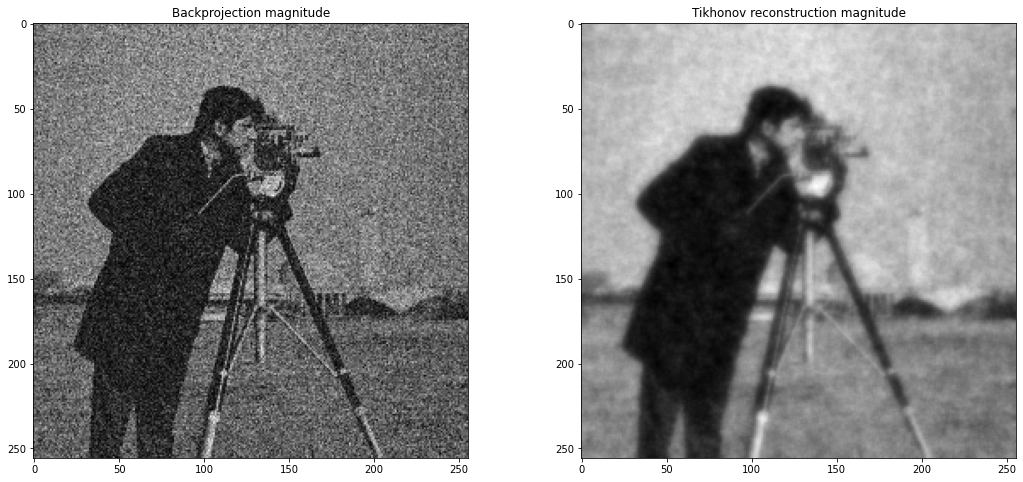

In [129]:
fig, axs = plt.subplots(1, 2, figsize=(18,8))

axs[0].imshow(np.abs(back_proj), cmap="gray")
axs[0].set_title("Backprojection magnitude")
axs[1].imshow(data["magnitude"], cmap="gray")
axs[1].set_title("Tikhonov reconstruction magnitude")

plt.show()

# Also solve with non-convex IAS?

In [136]:
# Hyper-prior parameters
hyperparameters = {
    "r": -1,
    "s": 1,
    "vartheta": 0.5*1e-2,
}

In [137]:
csias_solver = CSIASSolver2D(noisy_obs, R, noise_sigma=noise_sigma)
data = csias_solver.solve_with_ias(hyperparameters=hyperparameters, n_iterations=10)

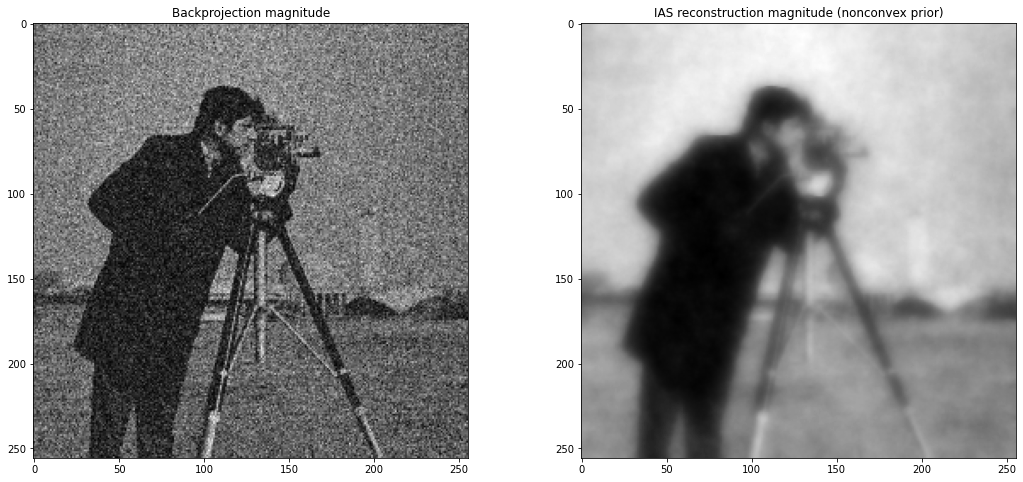

In [138]:
fig, axs = plt.subplots(1, 2, figsize=(18,8))

axs[0].imshow(np.abs(back_proj), cmap="gray")
axs[0].set_title("Backprojection magnitude")
axs[1].imshow(data["magnitude"], cmap="gray")
axs[1].set_title("IAS reconstruction magnitude (nonconvex prior)")

plt.show()

## Also solve with convex IAS?

In [143]:
# Hyper-prior parameters
hyperparameters = {
    "r": 1,
    "s": 1.5 + 1e-3,
    "vartheta": 0.5*1e-3,
}

In [144]:
csias_solver = CSIASSolver2D(noisy_obs, R, noise_sigma=noise_sigma)
convex_data = csias_solver.solve_with_ias(hyperparameters=hyperparameters, n_iterations=50)

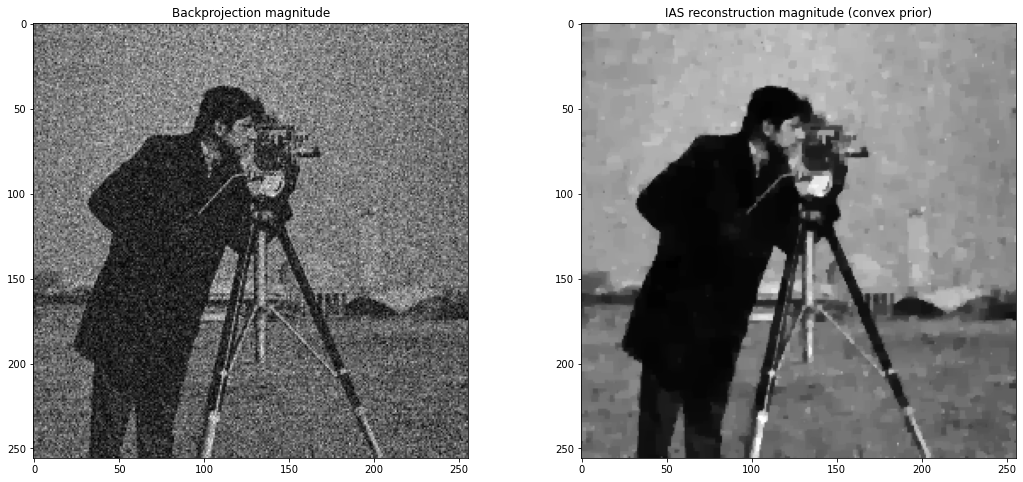

In [145]:
fig, axs = plt.subplots(1, 2, figsize=(18,8))

axs[0].imshow(np.abs(back_proj), cmap="gray")
axs[0].set_title("Backprojection magnitude")
axs[1].imshow(convex_data["magnitude"], cmap="gray")
axs[1].set_title("IAS reconstruction magnitude (convex prior)")

plt.show()

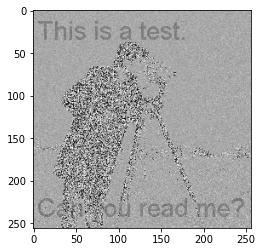

In [149]:
plt.imshow(convex_data["phase"], cmap="gray")
plt.show()